In [1]:
import pandas as pd
import numpy as np
import pickle
from google.colab import drive
import zipfile
drive.mount('content')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at content


# Data Input

In [ ]:
# optinal 
zip_name = 'content/Shared drives/玉山NLP/training_data/NEWS_斷詞.zip'#壓縮文件名
file_dir = 'content/Shared drives/玉山NLP/training_data/cut' #解壓後的文件放在該目錄下

with zipfile.ZipFile(zip_name, 'r') as myzip:
  for file in myzip.namelist():
    myzip.extract(file,file_dir)

text

In [2]:
raw_df = pd.read_csv("content/Shared drives/玉山NLP/training_data/cut/word_df.csv")
df = raw_df.copy()
df['word'] = df['word'].astype(str)
df = df.groupby("news_id")['word'].transform(lambda x: ' '.join(x)).drop_duplicates()

label_news_id = raw_df[raw_df.index.isin(df.index)].news_id.values

df = df.to_frame()
df = df.reset_index()
df = df.drop(["index"], axis=1)
texts = np.ravel(df.values)

label

In [3]:
label = pd.read_csv("content/Shared drives/玉山NLP/training_data/news_df.csv")
labels = pd.DataFrame({"news_id": label.news_ID.values, "label": label['name'] != "[]"})
label_news_id = pd.DataFrame(label_news_id)
label_news_id = label_news_id.rename(columns = {0: "news_id"})
labels = label_news_id.merge(labels, on="news_id", how='left').drop_duplicates().reset_index().drop(["index"], axis=1)

tokenize

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [5]:
maxlen = 500
max_words = 15000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

Found 100874 unique tokens.


In [6]:
training_samples = 4000
validation_samples = 893

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels.label[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

# word vector

In [7]:
# optinal 
dim = 0
word_vecs= {}

with open('/content/content/Shared drives/玉山NLP/w2v_CNA_ASBC_300d.vec', errors='ignore') as f:
  for line in f:
    # 假設我們的詞向量有300維
    # 由word以及向量中的元素共301個
    # 以空格分隔組成詞向量檔案中一行
    tokens = line.strip().split()

    # 第一行是兩個整數，分別代表有幾個詞向量，以及詞向量維度
    if len(tokens) == 2:
      dim = int(tokens[1])
      continue
    
    word = tokens[0] 
    vec = np.array([ float(t) for t in tokens[1:] ])
    word_vecs[word] = vec

# 之後可以從word_vecs這個dict中取得詞向量

a_file = open("wordvec.pkl", "wb")
pickle.dump(word_vecs, a_file)
a_file.close()

'''
ref:
https://fgc.stpi.narl.org.tw/activity/videoDetail/4b1141305ddf5522015de5479f4701b1
https://github.com/Embedding/Chinese-Word-Vectors/issues/13
'''

'\nref:\nhttps://fgc.stpi.narl.org.tw/activity/videoDetail/4b1141305ddf5522015de5479f4701b1\nhttps://github.com/Embedding/Chinese-Word-Vectors/issues/13\n'

In [ ]:
a_file = open("wordvec.pkl", "rb")
word_vecs = pickle.load(a_file)
a_file.close()

# word-embeddings matrix

In [8]:
embedding_dim = 300
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = word_vecs.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

# modeling

In [9]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(256, return_sequences=True)) 
model.add(LSTM(256, return_sequences=True)) 
model.add(LSTM(128)) 
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          4500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 256)          570368    
_________________________________________________________________
lstm_2 (LSTM)                (None, 500, 256)          525312    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 5,792,929
Trainable params: 5,792,929
Non-trainable params: 0
_________________________________________________________________


load pretrain

In [10]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [11]:
model.compile(optimizer='rmsprop',
  loss='binary_crossentropy',
  metrics=['acc'])

history = model.fit(x_train, y_train,
  epochs=10,
  batch_size=32,
  validation_data=(x_val, y_val))
model.save_weights('pre_trained_model.h5')

Train on 4000 samples, validate on 893 samples
Epoch 1/10
4000/4000 [==============================] - 315s 79ms/step - loss: 0.2468 - acc: 0.9107 - val_loss: 0.2462 - val_acc: 0.9351
Epoch 2/10
4000/4000 [==============================] - 313s 78ms/step - loss: 0.2060 - acc: 0.9295 - val_loss: 0.1998 - val_acc: 0.9351
Epoch 3/10
4000/4000 [==============================] - 312s 78ms/step - loss: 0.1735 - acc: 0.9312 - val_loss: 0.1519 - val_acc: 0.9507
Epoch 4/10
4000/4000 [==============================] - 313s 78ms/step - loss: 0.1470 - acc: 0.9415 - val_loss: 0.1718 - val_acc: 0.9406
Epoch 5/10
4000/4000 [==============================] - 314s 78ms/step - loss: 0.1435 - acc: 0.9327 - val_loss: 0.1304 - val_acc: 0.9474
Epoch 6/10
4000/4000 [==============================] - 320s 80ms/step - loss: 0.1240 - acc: 0.9465 - val_loss: 0.1506 - val_acc: 0.9351
Epoch 7/10
4000/4000 [==============================] - 320s 80ms/step - loss: 0.1212 - acc: 0.9530 - val_loss: 0.1416 - val_acc: 0

# Plotting

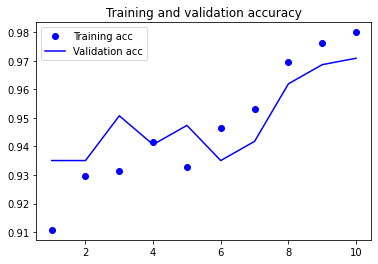

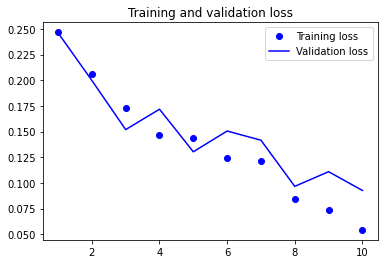

In [12]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()